In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

import nltk
from string import punctuation
from nltk.corpus import stopwords
from stop_words import get_stop_words
import texthero as hero
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans

# 1. Chargement du jeu de données

In [2]:
df = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


## 1.1 Exploration du jeu de données

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
df.shape

(1050, 15)

### Détail des colonnes

In [5]:
dict_colonnes = {
    'uniq id': 'Identifiant unique donné par le site web',
    'crawl_timestamp': 'horodatage',
    'product_url': 'URL du produit',
    'product_name': 'nom du produit',
    'product_category_tree': 'arbre des catégories du produit',
    'pid': 'identifiant du produit',
    'retail_price': 'prix au détail',
    'discounted_price': 'prix avec rabais',
    'image': 'nom de l\'image',
    'is_FK_Advantage_product': 'produit avec avantage flipkart',
    'description': 'description du produit',
    'product_rating': 'évaluation du produit',
    'overall_rating': 'note globale',
    'brand': 'marque du produit',
    'product_specifications': 'caractéristiques du produit',
}

pd.DataFrame(list(dict_colonnes.items()),
             columns=['Nom anglais de la colonne',
                      'Traduction / Signification'])

,Nom anglais de la colonne,Traduction / Signification
0,uniq id,Identifiant unique donné par le site web
1,crawl_timestamp,horodatage
2,product_url,URL du produit
3,product_name,nom du produit
4,product_category_tree,arbre des catégories du produit
5,pid,identifiant du produit
6,retail_price,prix au détail
7,discounted_price,prix avec rabais
8,image,nom de l'image
9,is_FK_Advantage_product,produit avec avantage flipkart


## 1.2 Sélection de variables

Notre objectif est de __déterminer la catégorie de produit en ne disposant que de l'image et de la description textuelle.__

Nous conservons la valeur `product_name` comme clé primaire pour identifier les produits.

Ensuite, nous supprimons toutes les colonnes à l'exception : d'image, de description, et de product_category_tree.

In [6]:
df = df[["product_name", "image", "description", "product_category_tree"]]

## 1.3 Colonne 'product_category_tree'

In [7]:
df.loc[0, 'product_category_tree']

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [8]:
df['product_category'] = df['product_category_tree'].apply(lambda x: x.split(" >>")[0][2:])

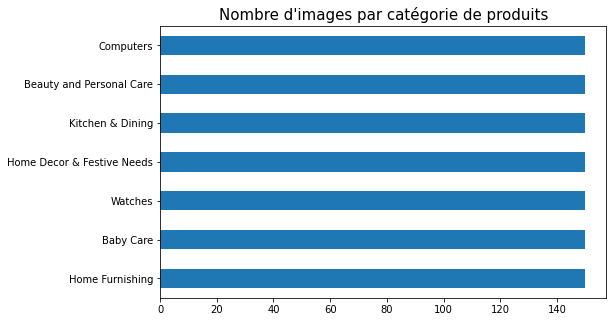

In [9]:
df['product_category'].value_counts().plot(kind='barh', figsize=(8, 5))
plt.title("Nombre d'images par catégorie de produits", fontsize=15)
plt.show()

Nous disposons de __7 catégories__ de produits, avec __150 produits par catégorie.__ Il existe des catégories plus précises pour chaque produit, néanmoins nous risquerions de ne plus disposer de suffisamment d'image et de description par catégorie. Par conséquent, nous resterons à ce niveau de granularité. 

# 2. Phase de prétraitement : données textuelles

__Objectif__ : réduire un document à une série de mots les plus représentatifs du texte.

In [10]:
data_clean = df.copy()

## 2.1 Nettoyage / Normalisation

__Nettoyage :__

- passage en minuscule
- tokenisation
- retrait des stop words
- suppression des chiffres
- ponctuation

__Normalisation :__

- stemming (racinisation)
- lemmatisation

### 2.1.1 Stop words

Nous allons ajouter quelques stop words présents dans nos 7 catégories. Pour nous faciliter la tâche, nous allons utiliser une méthode visuelle, avec wordcloud

In [11]:
#liste élargie de stop words
stop_words = list(get_stop_words("en")) 
nltk_words = list(stopwords.words("english"))
stop_words.extend(nltk_words)
stop_words = list(set(stop_words))
print("Nombre de stop words :", len(stop_words))

# Suppression des stop words
data_clean['description'] = hero.remove_stopwords(data_clean['description'], stop_words)

Nombre de stop words : 211


PRODUCT CATEGORY : Home Furnishing
PRODUCT CATEGORY : Baby Care
PRODUCT CATEGORY : Watches
PRODUCT CATEGORY : Home Decor & Festive Needs
PRODUCT CATEGORY : Kitchen & Dining
PRODUCT CATEGORY : Beauty and Personal Care
PRODUCT CATEGORY : Computers


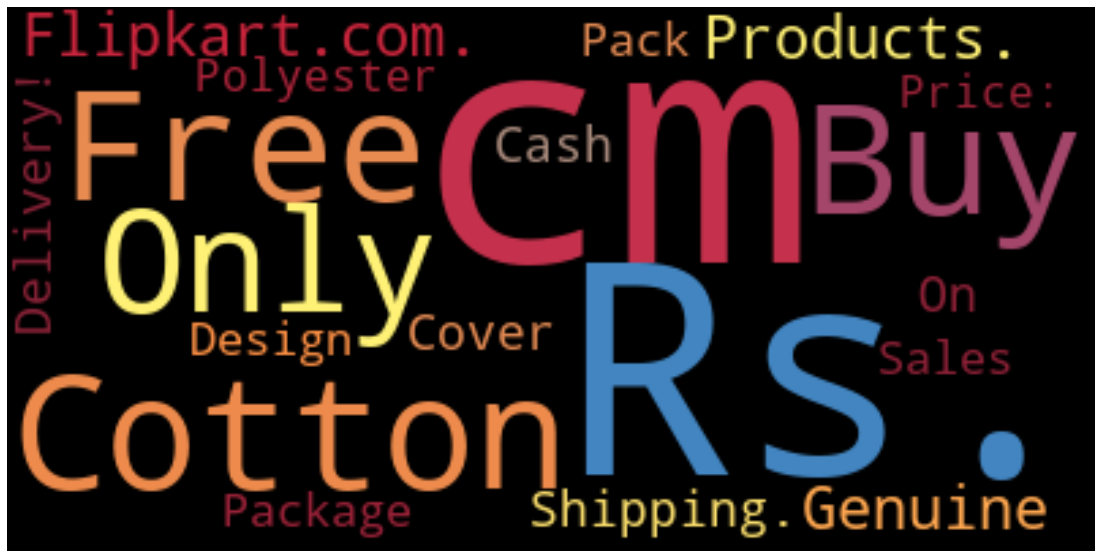

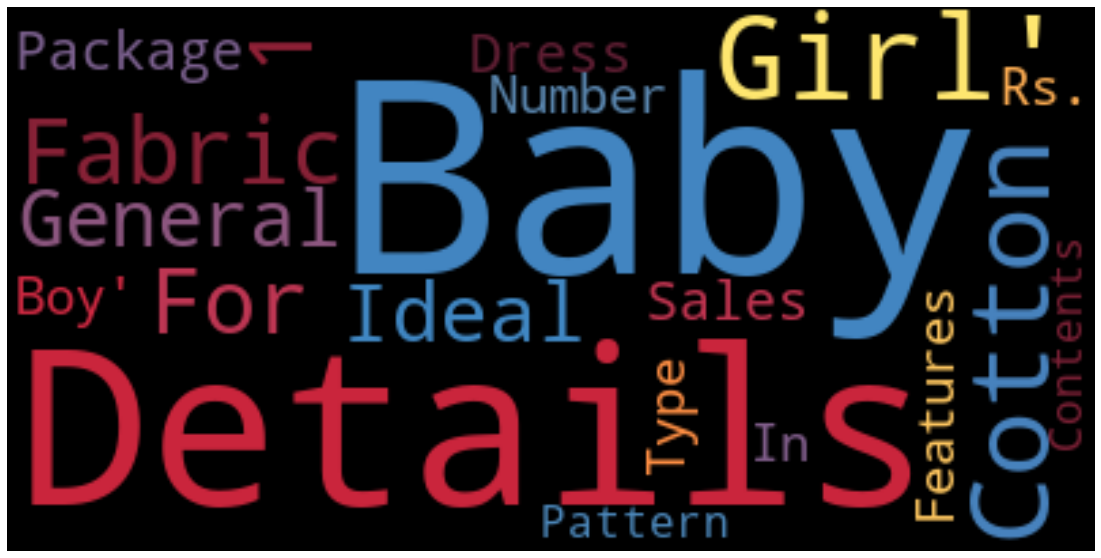

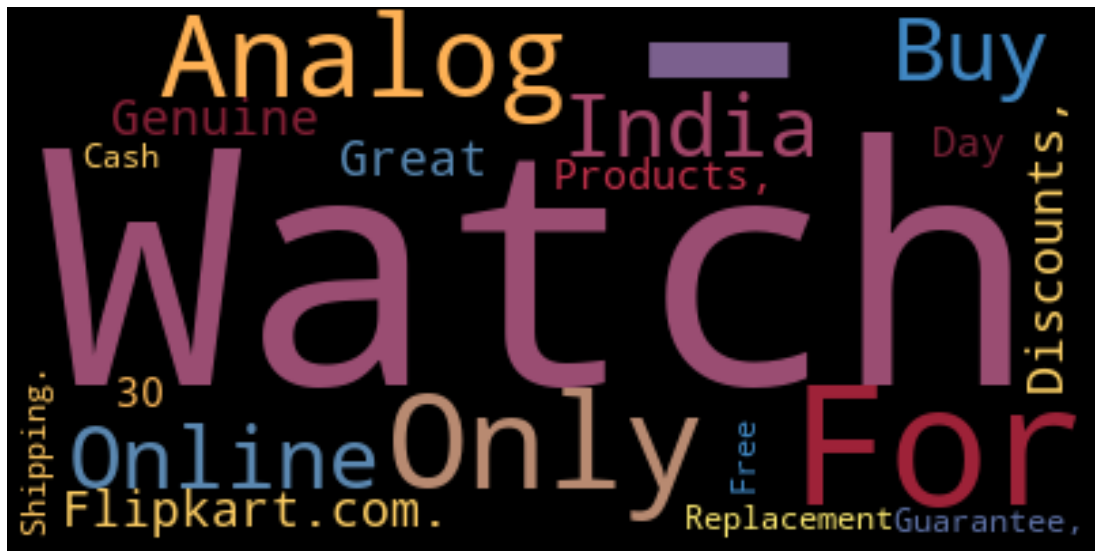

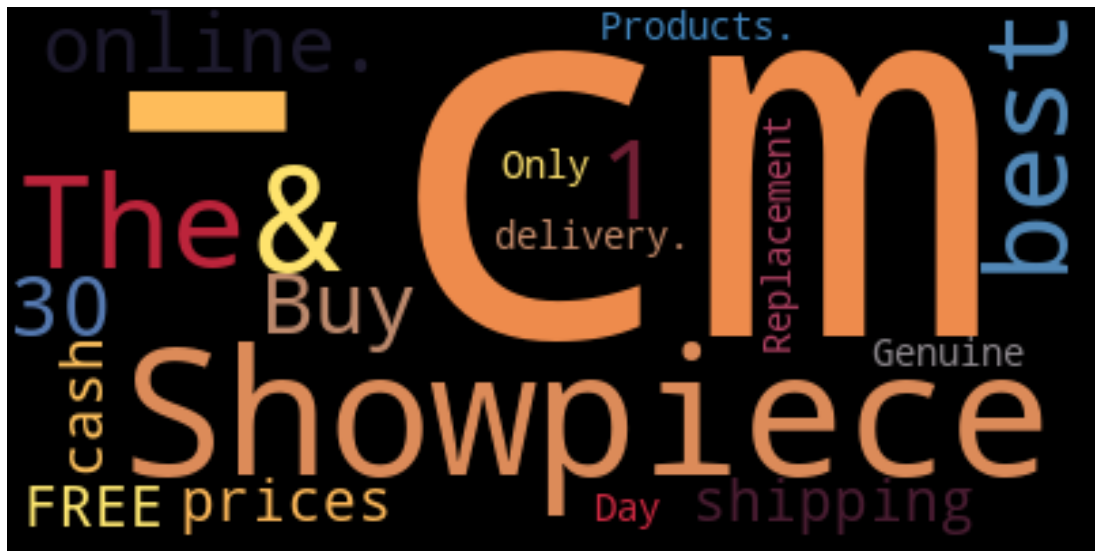

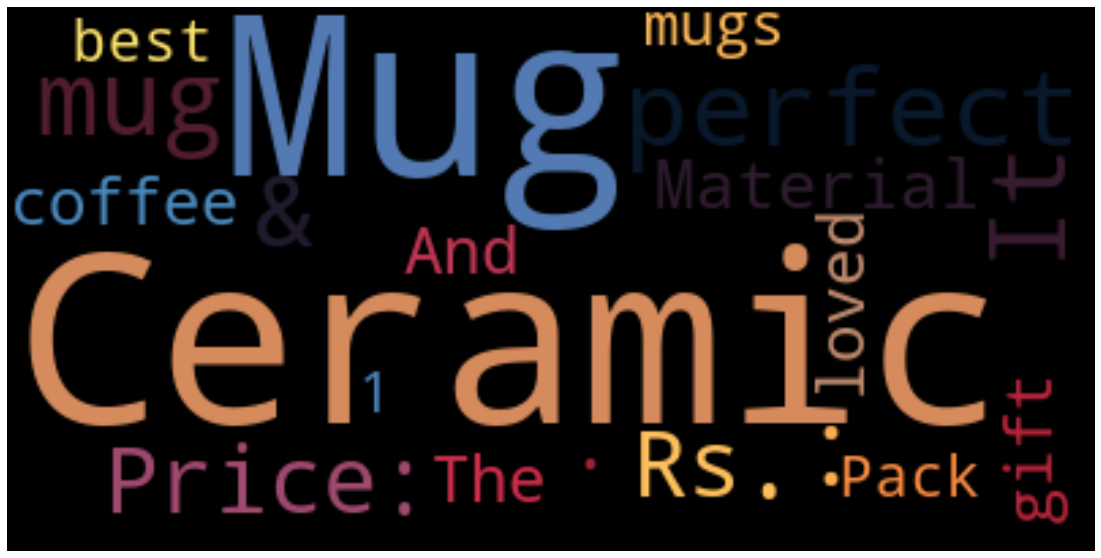

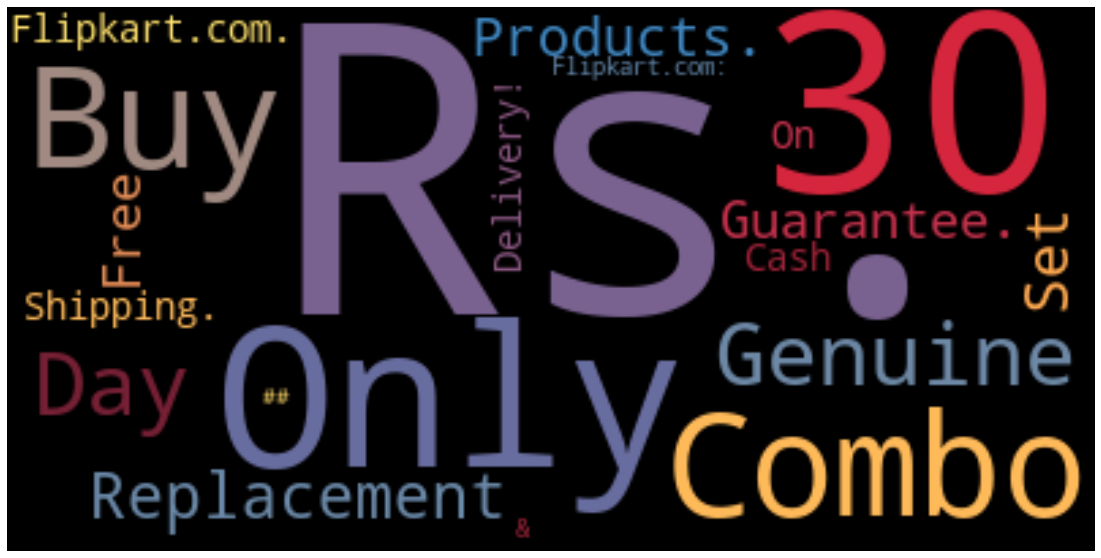

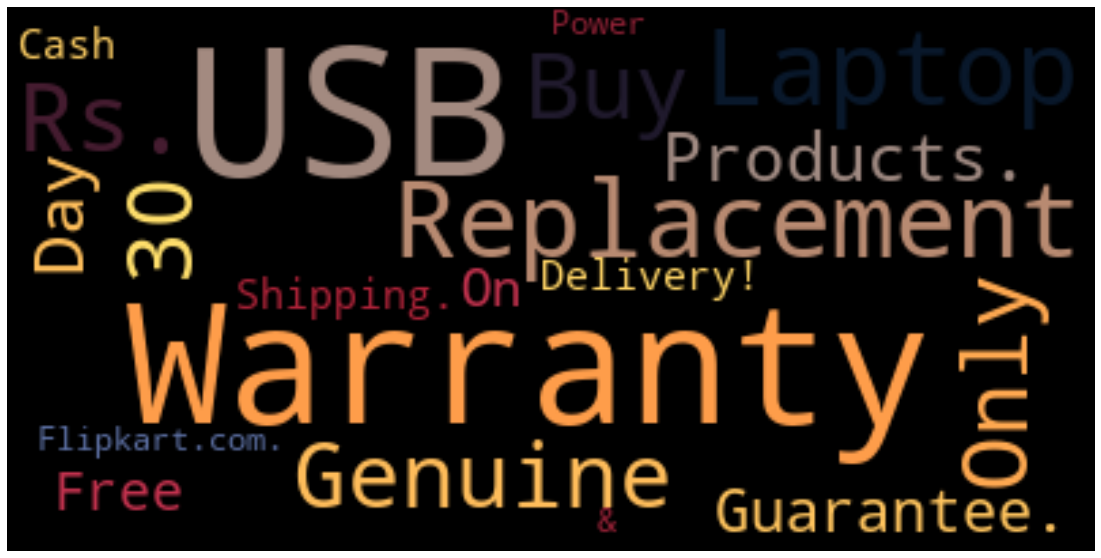

In [12]:
for cat in data_clean['product_category'].unique():
    print(f"PRODUCT CATEGORY : {cat}")
    hero.wordcloud(data_clean[data_clean['product_category'] == cat]['description'],
                   background_color='black',
                   max_words=20)

In [13]:
#Mots ajoutés aux stop words après inspection visuelle
new_words = ('buy', 'flipkart', 'shipping', 'genuine', 'cash', 'day', 'free', 'com', 'rs', 
             'products', 'product', 'package', 'price', 'prices', 'delivery', 'features')
#liste totale
stop_words.extend(new_words)

In [14]:
print(stop_words)

["you've", 'were', 'under', 'could', 'more', 'or', 'any', 'what', "mightn't", 'myself', 'they', "weren't", 'yourself', 'ought', 'is', "should've", 'wouldn', 'from', 'ours', "where's", 'me', 'above', "shan't", 'ma', 'was', 'yourselves', 'here', 'who', 'yours', "isn't", 'on', 'after', 'its', 'itself', 'am', "they've", 'doing', 'too', 'which', 'them', "he'll", 'down', 'until', 'an', 'that', "wouldn't", 'by', "who's", 'i', 'aren', 'against', 'below', 'had', "needn't", 'all', "there's", 'o', 'in', "shouldn't", 'how', 'very', 'themselves', "we'll", 'hadn', "won't", "hasn't", 'whom', 'has', 'just', 'with', 'have', 't', 'a', 'both', 'own', 'why', "you'd", 'cannot', "didn't", "i'll", 'won', 'then', 'couldn', "you'll", 'as', 'off', "that's", "it's", 'did', 'for', "i'm", 'there', 'and', "they'll", 'isn', 'it', 'if', "let's", 'ourselves', "why's", 'so', 'where', 'shan', "how's", "you're", "we're", 'most', "they're", 'those', 'to', 're', 'do', 'about', 'now', 'being', 'few', 'such', 'mightn', 'out'

### 2.1.2 Nettoyage des données textuelles

In [15]:
def preprocess_text(df, col):
    print("-"*100)
    print("Texte brut:")
    print(df[col][42])
    print("-"*100)
         
    # lowercase all texts in a series
    df[col] = hero.lowercase(df[col])
    print("Passage en minuscule :")
    print(df[col][42])
    print("-"*100)
    
    # remove all digits (worddigit)
    df[col] = hero.remove_digits(df[col], only_blocks=False)
    print("Retrait des nombres :")
    print(df[col][42])
    print("-"*100)
    
    # Remove stopwords
    df[col] = hero.remove_stopwords(df[col], stop_words)
    print("Retrait des stop words :")
    print(df[col][42])
    print("-"*100)
    
    # Remove punctuation            
    df[col] = hero.remove_punctuation(df[col]) 
    print("Retrait de la ponctuation :")
    print(df[col][42])
    print("-"*100)
        
    # Remove whitespace
    df[col] = hero.remove_whitespace(df[col])
    print("Retrait des espaces :")
    print(df[col][42])
    print("-"*100)
    
    return df

In [16]:
preprocess_text(data_clean, 'description')

----------------------------------------------------------------------------------------------------
Texte brut:
Key Features  Mom  Kid Baby Girl' Printed Blue, Grey Top & Pyjama Set Fabric: Cotton Brand Color: Blue, Grey,Mom  Kid Baby Girl' Printed Blue, Grey Top & Pyjama Set Price: Rs. 309 Girls Pyjamaset,Specifications  Mom  Kid Baby Girl' Printed Blue, Grey Top & Pyjama Set General Details Pattern Printed Ideal For Baby Girl' Night Suit Details Number  Contents  Sales Package Pack  1 Fabric Cotton Type Top & Pyjama Set Neck Round Nack In  Box 1 Top & Pyjama Set
----------------------------------------------------------------------------------------------------
Passage en minuscule :
key features  mom  kid baby girl' printed blue, grey top & pyjama set fabric: cotton brand color: blue, grey,mom  kid baby girl' printed blue, grey top & pyjama set price: rs. 309 girls pyjamaset,specifications  mom  kid baby girl' printed blue, grey top & pyjama set general details pattern printed idea

,product_name,image,description,product_category_tree,product_category
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key elegance polyester multicolor abstract eye...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,specifications sathiyas cotton bath towel bath...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,key eurospa cotton terry face towel set size s...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,key santosh royal fashion cotton printed king ...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,key jaipur print cotton floral king sized doub...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,oren empower extra large self adhesive sticker...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,wallmantra large vinyl sticker sticker pack br...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,uberlyfe extra large pigmented polyvinyl films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,wallmantra medium vinyl sticker sticker online...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care


### 2.1.3 Analyse de la colonne description après nettoyage

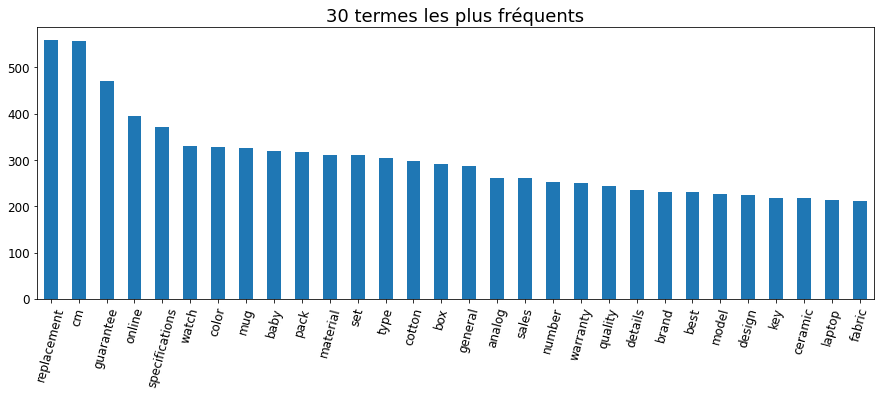

In [17]:
vectorizer = CountVectorizer(max_features=30)

bag_of_words = vectorizer.fit_transform(data_clean['description'])

bag_of_words = pd.DataFrame(data=bag_of_words.toarray(),
                            columns=vectorizer.get_feature_names())
plt.figure(figsize=(15, 5))
bag_of_words.sum().sort_values(ascending=False).plot.bar()
plt.title("30 termes les plus fréquents", fontsize=18)
plt.xticks(fontsize=12, rotation=75)
plt.yticks(fontsize=12)
plt.show()

In [18]:
bag_of_words['product_category'] = data_clean['product_category']

In [19]:
bag_of_words = bag_of_words.groupby('product_category')[
    vectorizer.get_feature_names()].sum().reset_index().T

In [20]:
new_header = bag_of_words.iloc[0]
bag_of_words = bag_of_words[1:]
bag_of_words.columns = new_header
bag_of_words = bag_of_words.reset_index()
bag_of_words = bag_of_words.rename(columns={'index': 'word'})
bag_of_words['sum'] = bag_of_words.iloc[:, 1:].sum(axis=1)
bag_of_words = bag_of_words.sort_values('sum', ascending=False)
bag_of_words.head()

product_category,word,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches,sum
23,replacement,14,105,176,76,3,51,134,559.0
6,cm,46,10,6,283,194,19,0,558.0
13,guarantee,14,101,96,76,0,50,134,471.0
20,online,26,83,26,78,0,49,134,396.0
26,specifications,100,40,53,37,47,84,10,371.0


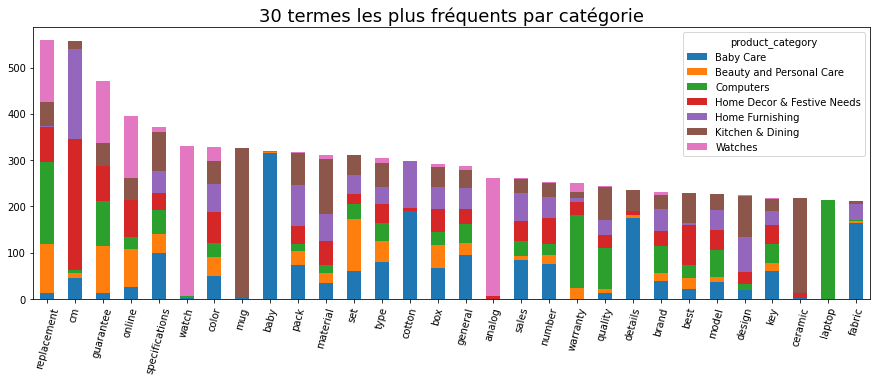

In [21]:
bag_of_words.iloc[:, :-1].plot(x='word',
                  kind='bar',
                  stacked=True,
                  figsize=(15, 5))
plt.title("30 termes les plus fréquents par catégorie", fontsize=18)
plt.xlabel("")
plt.xticks(rotation=75)
plt.show()

### 2.1.4  Stemming et lemmatisation

In [22]:
data_lemmatization = data_clean.copy()
data_stemming = data_clean.copy()

### Stemming

In [23]:
def stemmatizer(df, col):
    df[col] = hero.stem(df[col], stem='porter')
    return df

In [24]:
stemmatizer(data_stemming, 'description')

,product_name,image,description,product_category_tree,product_category
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key eleg polyest multicolor abstract eyelet do...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,specif sathiya cotton bath towel bath towel re...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,key eurospa cotton terri face towel set size s...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,key santosh royal fashion cotton print king si...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,key jaipur print cotton floral king size doubl...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,oren empow extra larg self adhes sticker pack ...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,wallmantra larg vinyl sticker sticker pack bri...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,uberlyf extra larg pigment polyvinyl film impo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,wallmantra medium vinyl sticker sticker onlin ...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care


### Lemmatisation

In [25]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [26]:
data_lemmatization['description'] = data_lemmatization['description'].apply(lemmatize_text).astype(str)
preprocess_text(data_lemmatization, 'description')

----------------------------------------------------------------------------------------------------
Texte brut:
['key', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'fabric', 'cotton', 'brand', 'color', 'blue', 'grey', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'girl', 'pyjamaset', 'specification', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'general', 'detail', 'pattern', 'printed', 'ideal', 'baby', 'girl', 'night', 'suit', 'detail', 'number', 'content', 'sale', 'pack', 'fabric', 'cotton', 'type', 'top', 'pyjama', 'set', 'neck', 'round', 'nack', 'box', 'top', 'pyjama', 'set']
----------------------------------------------------------------------------------------------------
Passage en minuscule :
['key', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'fabric', 'cotton', 'brand', 'color', 'blue', 'grey', 'mom', 'kid', 'baby', 'girl', 'printe

,product_name,image,description,product_category_tree,product_category
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key elegance polyester multicolor abstract eye...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,specification sathiyas cotton bath towel bath ...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,key eurospa cotton terry face towel set size s...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,key santosh royal fashion cotton printed king ...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,key jaipur print cotton floral king sized doub...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,oren empower extra large self adhesive sticker...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,wallmantra large vinyl sticker sticker pack br...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,uberlyfe extra large pigmented polyvinyl film ...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,wallmantra medium vinyl sticker sticker online...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care


## 2.3 Visualisation des transformations effectuées

In [27]:
data_token = df.copy()
data_token['description'] = hero.lowercase(data_token['description'])
tokenization = data_token['description'][103]
tokenization = word_tokenize(tokenization)

In [28]:
original = df['description'][103]
pretraitement = data_clean['description'][103]
stemming = data_stemming['description'][103]
lemmatization = data_lemmatization['description'][103]

In [29]:
df_traitement = pd.DataFrame.from_dict({
    'ORIGINAL':original,
    'TOKENISATION': tokenization,
    'PRETRAITEMENT': pretraitement,
    'STEMMING': stemming,
    'LEMMATISATION':lemmatization},
    orient='index')

In [30]:
df_traitement = df_traitement.rename(columns={0: 'Exemple'})

In [31]:
pd.set_option('display.max_colwidth', 200)
df_traitement

,Exemple
ORIGINAL,Buy Rama Floral Single Quilts & Comforters Pink-Red at Rs. 749 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!
TOKENISATION,"[buy, rama, floral, single, quilts, &, comforters, pink-red, at, rs, ., 749, at, flipkart.com, ., only, genuine, products, ., free, shipping, ., cash, on, delivery, !]"
PRETRAITEMENT,rama floral single quilts comforters pink red
STEMMING,rama floral singl quilt comfort pink red
LEMMATISATION,rama floral single quilt comforter pink red


## 2.4 Vectorisation

### 2.4.1 CountVectorizer

In [32]:
data_stemming_CV = data_stemming.copy()
data_lemmatization_CV = data_lemmatization.copy()

### Sur jeu de données avec stemming

In [33]:
vectorizer_cv = CountVectorizer()
vectorizer_cv.fit(data_stemming_CV['description'])
vector_stemming_CV = vectorizer_cv.transform(data_stemming_CV['description']).toarray()
vector_stemming_CV_df = pd.DataFrame(vector_stemming_CV)
vector_stemming_CV_df.to_csv('data/data_stemming_CV.csv')

In [35]:
vector_stemming_CV.shape

(1050, 4088)

In [63]:
# Count Vectorizer with stemming
pd.DataFrame(
    data = vector_stemming_CV,
    columns = vectorizer_cv.get_feature_names()
).iloc[:5, 10:20]

,abroad,absolut,absorb,abstract,abstrct,ac,accent,access,accessori,accid
0,0,0,0,4,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### Sur jeu de données avec lemmatisation

In [64]:
vectorizer_cv = CountVectorizer()
vectorizer_cv.fit(data_lemmatization_CV['description'])
vector_lemmatization_CV = vectorizer_cv.transform(data_lemmatization_CV['description']).toarray()
vector_lemmatization_CV_df = pd.DataFrame(vector_lemmatization_CV)
vector_lemmatization_CV_df.to_csv('data/data_lemmatization_CV.csv')

### 2.4.2 TF-IDF

In [65]:
data_stemming_tfidf = data_stemming.copy()
data_lemmatization_tfidf = data_lemmatization.copy()

### Sur jeu de données avec stemming

In [77]:
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(data_stemming_tfidf['description'])
vector_stemming_tfidf = vectorizer_tfidf.transform(data_stemming_tfidf['description']).toarray()
vector_stemming_tfidf_df = pd.DataFrame(vector_stemming_tfidf)
vector_stemming_tfidf_df.to_csv('data/data_stemming_tfidf.csv')

In [78]:
vector_stemming_tfidf.shape

(1050, 4088)

In [79]:
len(vectorizer_tfidf.get_feature_names())

4088

In [81]:
# Count Vectorizer with stemming
pd.DataFrame(
    vector_stemming_tfidf,
    columns=vectorizer_tfidf.get_feature_names()
).iloc[:5, 10:20]

,abroad,absolut,absorb,abstract,abstrct,ac,accent,access,accessori,accid
0,0.0,0.0,0.000000,0.171482,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.052647,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Sur jeu de données avec lemmatisation

In [82]:
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(data_lemmatization_tfidf['description'])
vector_lemmatization_tfidf = vectorizer_tfidf.transform(data_lemmatization_tfidf['description']).toarray()
vector_lemmatization_tfidf_df = pd.DataFrame(vector_lemmatization_tfidf)
vector_lemmatization_tfidf_df.to_csv('data/data_lemmatization_tfidf.csv')

# 3. Reduction de dimension et clustering

## 3.1 Normalisation : stemming / Vectorisation : Count vectorizer

### PCA 

In [81]:
print("Dimensions dataset avant réduction PCA : ", vector_stemming_CV.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(vector_stemming_CV)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4088)
Dimensions dataset après réduction PCA :  (1050, 563)


### TSNE

In [82]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80,
            n_iter=5000, learning_rate=200, random_state=42)
tsne_df_results = tsne.fit_transform(feat_pca)
tsne_df_stem_CV = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])
tsne_df_stem_CV.head(3)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.875524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.823662
[t-SNE] KL divergence after 3400 iterations: 0.773341


,tsne1,tsne2
0,-1.255839,19.191862
1,-9.348417,3.292008
2,-11.394812,3.048199


### K-means clustering

In [83]:
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400,
                        init='k-means++', random_state=42).fit(tsne_df_stem_CV)

labels_tsne_df = kmeans_tsne_df.labels_

clusters_tsne_df = pd.concat([tsne_df_stem_CV,
                              pd.DataFrame({'tsne_clusters':labels_tsne_df})],
                              axis=1)

clusters_tsne_df.head(3)

,tsne1,tsne2,tsne_clusters
0,-1.255839,19.191862,3
1,-9.348417,3.292008,5
2,-11.394812,3.048199,1


### Analyse des résultats du clustering

In [84]:
data_stemming_CV['cluster'] = labels_tsne_df
categories_true = data_stemming_CV['product_category']
categories_predict = data_stemming_CV['cluster']
ari = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f" % ari)

Adjusted Rand Index: 0.403


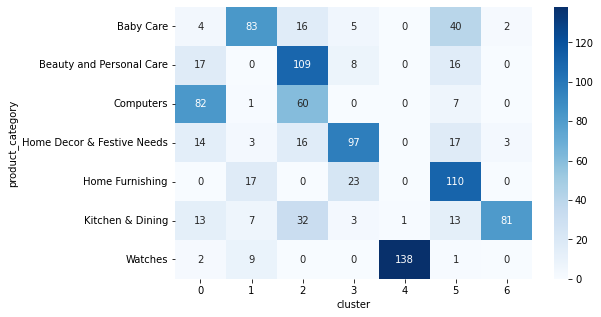

In [85]:
plt.figure(figsize=(8, 5))
conf_mat = pd.crosstab(categories_true, categories_predict)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.show()

### Visualisation du clustering

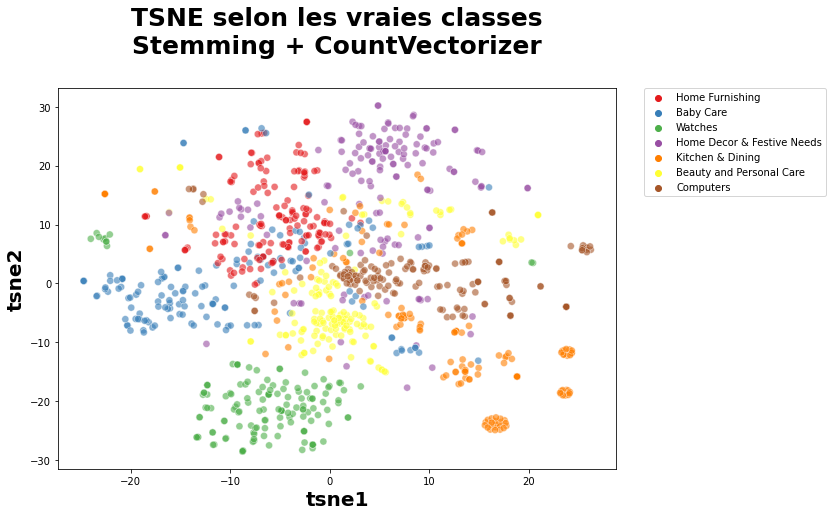

In [86]:
plt.figure(figsize = (10, 7))
sns.scatterplot(clusters_tsne_df.iloc[:,0],
                clusters_tsne_df.iloc[:,1],
                hue = categories_true,
                palette='Set1',
                s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes\nStemming + CountVectorizer',
          fontsize=25, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=20, fontweight='bold')
plt.ylabel('tsne2', fontsize=20, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 3.2 Normalisation : lemmatisation / Vectorisation : count vectorizer

In [87]:
print("Dimensions dataset avant réduction PCA : ", vector_lemmatization_CV.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(vector_lemmatization_CV)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4636)
Dimensions dataset après réduction PCA :  (1050, 571)


In [88]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80,
            n_iter=5000, learning_rate=200, random_state=42)
tsne_df_results = tsne.fit_transform(feat_pca)
tsne_df_lem_CV = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])
tsne_df_lem_CV.head(3)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 1.859067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.766838
[t-SNE] KL divergence after 3650 iterations: 0.770004


,tsne1,tsne2
0,0.724687,-22.535427
1,-7.394100,-2.385767
2,-7.997720,0.056697


## K-means clustering

In [89]:
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400,
                        init='k-means++', random_state=42).fit(tsne_df_lem_CV)

labels_tsne_df = kmeans_tsne_df.labels_

clusters_tsne_df = pd.concat([tsne_df_lem_CV,
                              pd.DataFrame({'tsne_clusters':labels_tsne_df})],
                             axis=1)

clusters_tsne_df.head(3)

,tsne1,tsne2,tsne_clusters
0,0.724687,-22.535427,1
1,-7.394100,-2.385767,0
2,-7.997720,0.056697,0


### Analyse des résultats du clustering

In [90]:
data_lemmatization_CV['cluster'] = labels_tsne_df
categories_true = data_lemmatization_CV['product_category']
categories_predict = data_lemmatization_CV['cluster']
ari = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f" % ari)

Adjusted Rand Index: 0.392


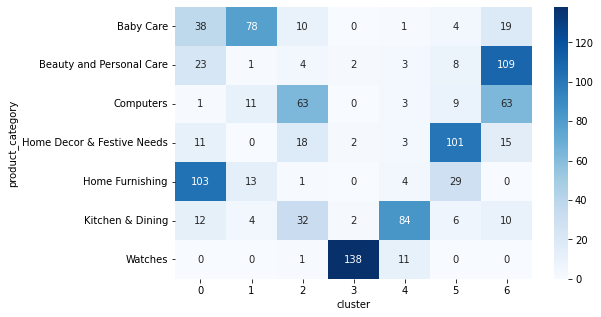

In [91]:
plt.figure(figsize=(8, 5))
conf_mat = pd.crosstab(categories_true, categories_predict)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.show()

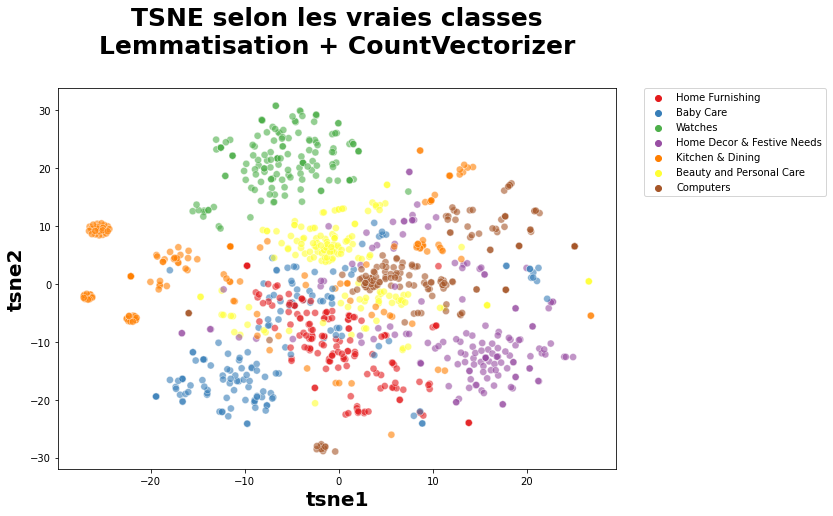

In [92]:
plt.figure(figsize = (10, 7))
sns.scatterplot(clusters_tsne_df.iloc[:,0],
                clusters_tsne_df.iloc[:,1],
                hue = categories_true,
                palette='Set1',
                s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes\nLemmatisation + CountVectorizer',
          fontsize=25, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=20, fontweight='bold')
plt.ylabel('tsne2', fontsize=20, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 3.3 Normalisation : stemming / Vectorisation : TF-IDF

In [93]:
print("Dimensions dataset avant réduction PCA : ", vector_stemming_tfidf.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(vector_stemming_tfidf)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4088)
Dimensions dataset après réduction PCA :  (1050, 806)


In [94]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80,
            n_iter=5000, learning_rate=200, random_state=42)
tsne_df_results = tsne.fit_transform(feat_pca)
tsne_df_stem_tfidf = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])
tsne_df_stem_tfidf.head(3)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.003s...
[t-SNE] Computed neighbors for 1050 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.419816
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.699249
[t-SNE] KL divergence after 4000 iterations: 0.775020


,tsne1,tsne2
0,-13.316809,-2.267542
1,-4.963339,7.281317
2,-5.084282,4.863408


In [95]:
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400,
                        init='k-means++', random_state=42).fit(tsne_df_stem_tfidf)

labels_tsne_df = kmeans_tsne_df.labels_

clusters_tsne_df = pd.concat([tsne_df_stem_tfidf,
                              pd.DataFrame({'tsne_clusters':labels_tsne_df})],
                             axis=1)

clusters_tsne_df.head(3)

,tsne1,tsne2,tsne_clusters
0,-13.316809,-2.267542,0
1,-4.963339,7.281317,0
2,-5.084282,4.863408,0


### Analyse des résultats du clustering

In [96]:
data_stemming_tfidf['cluster'] = labels_tsne_df
categories_true = data_stemming_tfidf['product_category']
categories_predict = data_stemming_tfidf['cluster']
ari = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f" % ari)

Adjusted Rand Index: 0.414


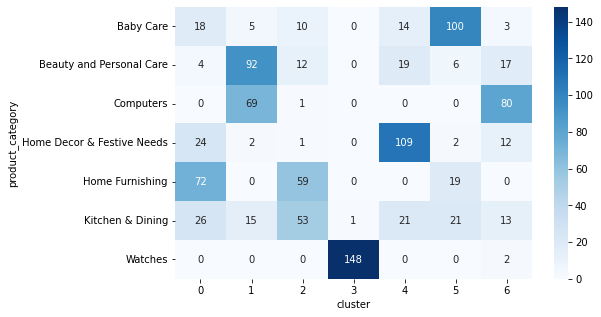

In [97]:
plt.figure(figsize=(8, 5))
conf_mat = pd.crosstab(categories_true, categories_predict)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.show()

### Visualisation du clustering

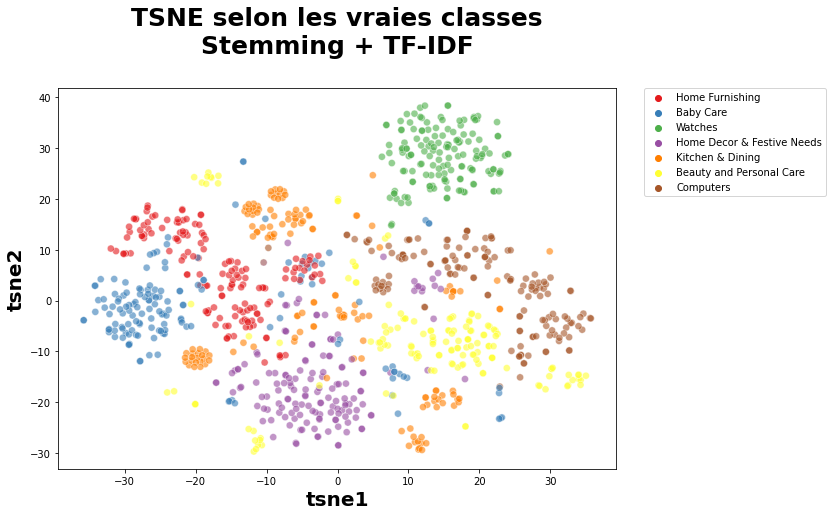

In [98]:
plt.figure(figsize = (10, 7))
sns.scatterplot(clusters_tsne_df.iloc[:,0],
                clusters_tsne_df.iloc[:,1],
                hue = categories_true,
                palette='Set1',
                s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes\nStemming + TF-IDF',
          fontsize=25, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=20, fontweight='bold')
plt.ylabel('tsne2', fontsize=20, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 3.4 Normalisation : lemmatisation / Vectorisation : TF-IDF

In [99]:
print("Dimensions dataset avant réduction PCA : ", vector_lemmatization_tfidf.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(vector_lemmatization_tfidf)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4636)
Dimensions dataset après réduction PCA :  (1050, 809)


In [100]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80,
            n_iter=5000, learning_rate=200, random_state=42)
tsne_df_results = tsne.fit_transform(feat_pca)
tsne_df_lem_tfidf = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])
tsne_df_lem_tfidf.head(3)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.414858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.146652
[t-SNE] KL divergence after 3200 iterations: 0.759295


,tsne1,tsne2
0,6.887403,18.174438
1,29.057032,-3.124782
2,26.913511,-4.472087


In [101]:
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400,
                        init='k-means++', random_state=42).fit(tsne_df_lem_tfidf)

labels_tsne_df = kmeans_tsne_df.labels_

clusters_tsne_df = pd.concat([tsne_df_lem_tfidf,
                              pd.DataFrame({'tsne_clusters':labels_tsne_df})],
                             axis=1)

clusters_tsne_df.head(3)

,tsne1,tsne2,tsne_clusters
0,6.887403,18.174438,2
1,29.057032,-3.124782,5
2,26.913511,-4.472087,5


### Analyse des résultats du clustering

In [102]:
data_lemmatization_tfidf['cluster'] = labels_tsne_df
categories_true = data_lemmatization_tfidf['product_category']
categories_predict = data_lemmatization_tfidf['cluster']
ari = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f" % ari)

Adjusted Rand Index: 0.482


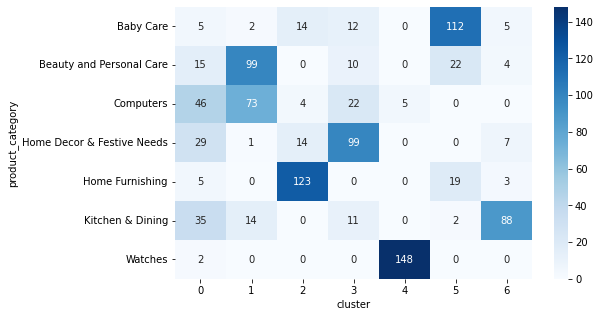

In [103]:
plt.figure(figsize=(8, 5))
conf_mat = pd.crosstab(categories_true, categories_predict)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.show()

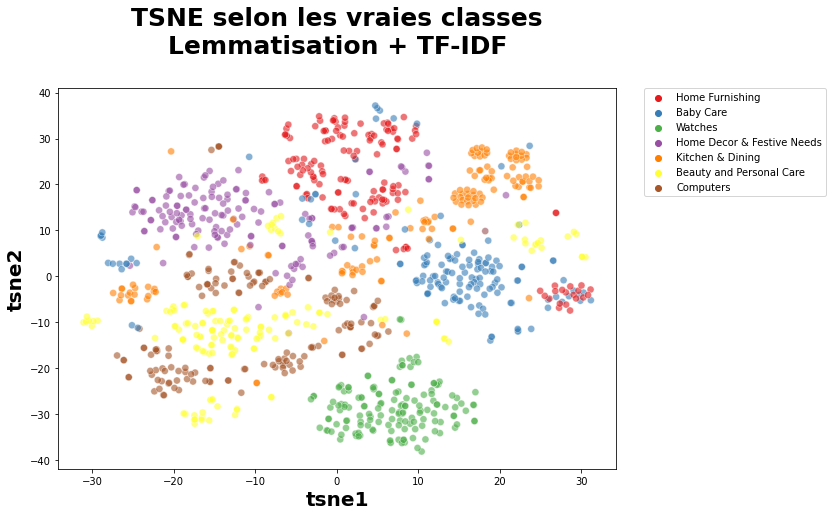

In [104]:
plt.figure(figsize = (10, 7))
sns.scatterplot(clusters_tsne_df.iloc[:,0],
                clusters_tsne_df.iloc[:,1],
                hue = categories_true,
                palette='Set1',
                s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes\nLemmatisation + TF-IDF',
          fontsize=25, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=20, fontweight='bold')
plt.ylabel('tsne2', fontsize=20, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()